In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.manifold import TSNE
from matplotlib.colors import LogNorm


### Definition of input and output files

In [3]:
inp_file_dev = '../data/assignment1_dev_set.csv'
inp_file_val = '../data/assignment1_val_set.csv'

In [4]:
out_file_dev = '../data/development_final_data.csv'
out_file_val = '../data/evaluation_final_data.csv'


# Section 1 Load data and present a brief overview
To check:
- number of rows/columns
- types of columns

In [5]:
df_dev = pd.read_csv(inp_file_dev)
print(f'The data set has {len(df_dev)} data points.')

The data set has 489 data points.


In [6]:
print(f'The data file has {len(df_dev.columns)} columns')

The data file has 141 columns


In [7]:
num_numeric = df_dev.select_dtypes(include=['number']).shape[1]
num_object = df_dev.select_dtypes(include=['object']).shape[1]

print(f'Numeric columns: {num_numeric}')
print(f'String (object) columns: {num_object}')

Numeric columns: 137
String (object) columns: 4


In [8]:
df_dev.dtypes

Unnamed: 0                     int64
Project ID                    object
Experiment type               object
Sex                           object
Host age                     float64
                              ...   
Clostridium xylanolyticum    float64
Eubacterium brachy           float64
Eubacterium dolichum         float64
Eubacterium sulci            float64
Ruminococcus gnavus          float64
Length: 141, dtype: object

In [9]:
string_columns = df_dev.select_dtypes(include=['object']).columns.tolist()
print(f'Columns that are string value: {string_columns}')

Columns that are string value: ['Project ID', 'Experiment type', 'Sex', 'Disease MESH ID']


# Section 2: Check and handle string/categorical values

In [10]:
len( df_dev['Experiment type'].value_counts())

1

`Experiment type` **column can be removed**

----


In [11]:
len( df_dev['Disease MESH ID'].value_counts())

1

`Disease MESH ID` **column can be removed**

----


In [12]:
len( df_dev['Project ID'].value_counts())


6

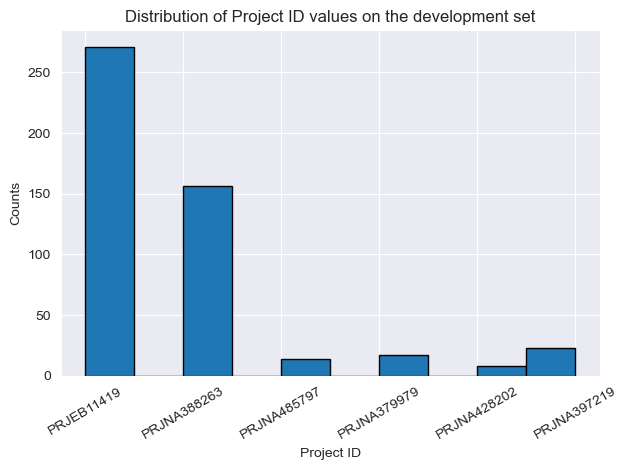

The correlation of the 'Project ID' column with the BMI target values is 0.10


In [31]:
plt.hist(df_dev['Project ID'], edgecolor='black')
plt.xlabel('Project ID')
plt.ylabel('Counts')
plt.title('Distribution of Project ID values on the development set')
plt.xticks(rotation=30)
plt.savefig('Distribution_of_project_ID_values.png')
plt.show()

df_dev['Project ID_encoded'] = pd.factorize(df_dev['Project ID'])[0]
correlation_projID_to_BMI = df_dev['Project ID_encoded'].corr(df_dev['BMI'])
print(f"The correlation of the 'Project ID' column with the BMI target values is {correlation_projID_to_BMI:.2f}")

df_dev.drop(columns=['Project ID_encoded'], inplace=True)

`Project ID` **column has few distinct values, while most data points only belong in two of them. It has a small correlation with the BMI values, so it can be removed.

----

In [14]:
df_dev['Sex'].value_counts()

Male      302
Female    187
Name: Sex, dtype: int64

In [15]:
# Transform 'Sex' values to 0 / 1 to keep them
df_dev['Sex'] = df_dev['Sex'].map({'Male': 0, 'Female': 1})

# Section 3: Plotting statistics of the data

## Section 3.1: Visualization of BMI values

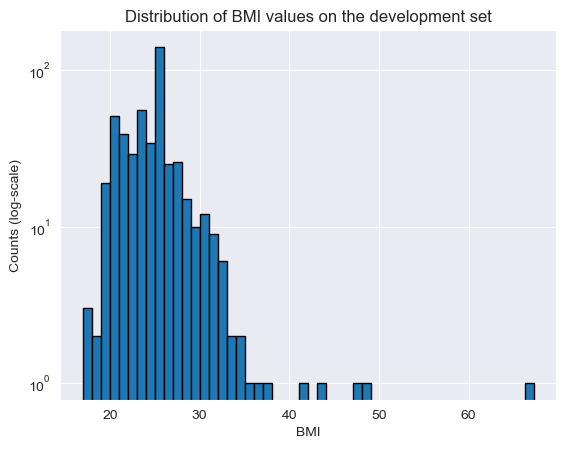

In [16]:
plt.hist(df_dev['BMI'], bins=50, edgecolor='black')
plt.xlabel('BMI')
plt.ylabel('Counts (log-scale)')
plt.title('Distribution of BMI values on the development set')
plt.yscale('log')
plt.savefig('BMI_distribution.png')
plt.show()

### BMI Classifications

- **Underweight**: BMI < 18.5
- **Normal weight**: 18.5 ≤ BMI < 25
- **Overweight**: 25 ≤ BMI < 30
- **Obesity Class 1 (Moderate)**: 30 ≤ BMI < 35
- **Obesity Class 2 (Severe)**: 35 ≤ BMI < 40
- **Obesity Class 3 (Very Severe)**: BMI ≥ 40

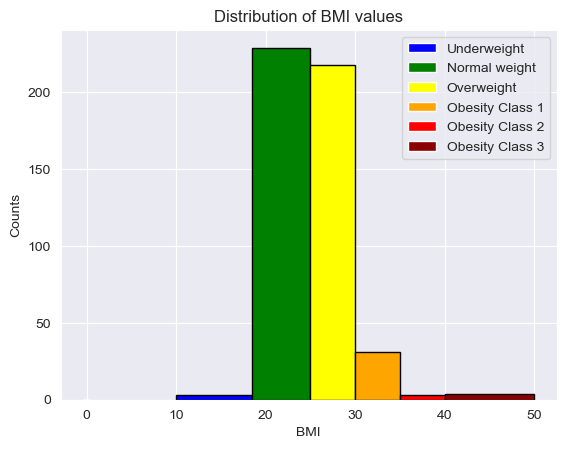

In [17]:
bins = [10, 18.5, 25, 30, 35, 40, 50]
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'darkred']
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity Class 1', 'Obesity Class 2', 'Obesity Class 3']

hist, bin_edges = np.histogram(df_dev['BMI'], bins=bins)
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')

for i, label in enumerate(labels):
    plt.bar(0, 0, color=colors[i], label=label)

plt.xlabel('BMI')
plt.ylabel('Counts')
plt.title('Distribution of BMI values')
plt.savefig('BMI_distribution_with_classes.png')
plt.legend()
plt.show()

# Section 3.2: Plotting correlations of all columns

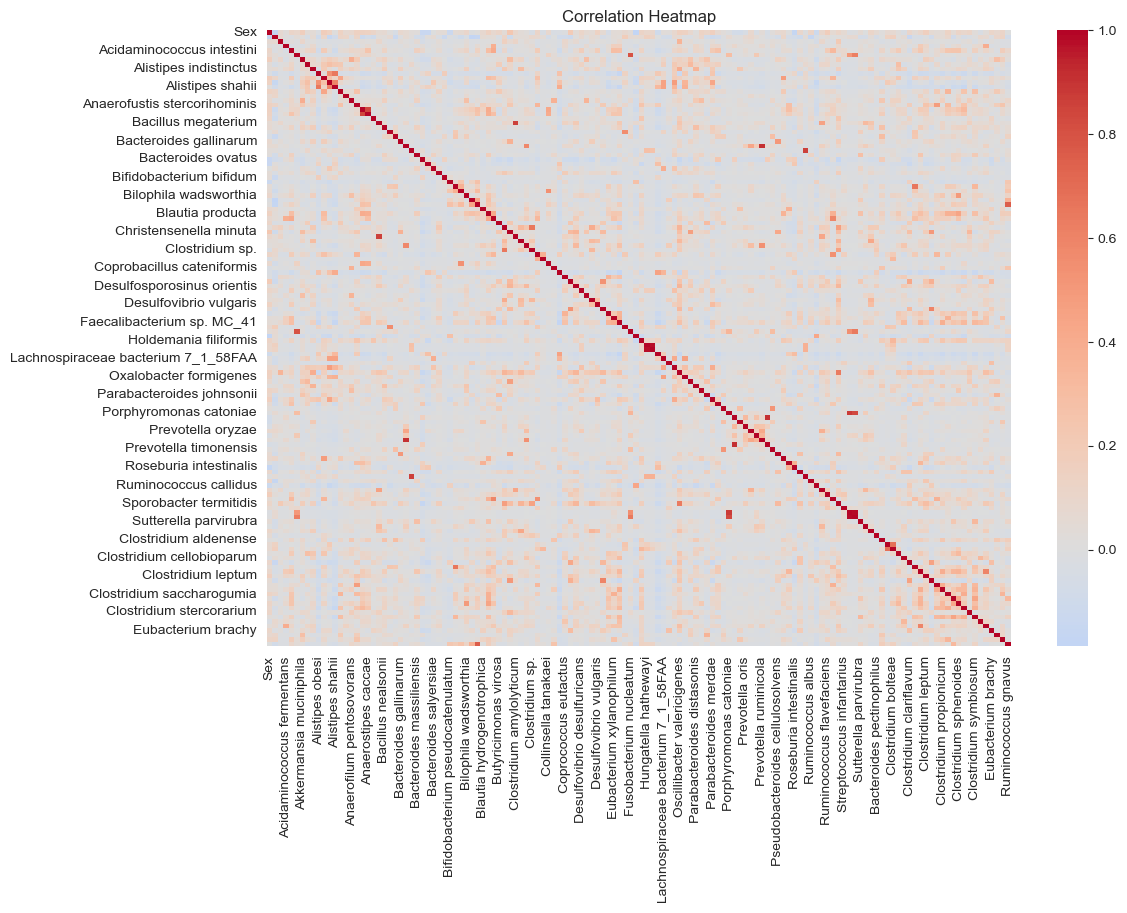

In [18]:
df2 = df_dev.drop(columns=['Experiment type', 'Unnamed: 0', 'Disease MESH ID', 'Project ID'])
df2 = df2.drop(columns=['BMI'])
plt.figure(figsize=(12, 8))
corr = df2.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.savefig('All_columns_correlation_heatmap.png')
plt.show()

**Few of the features have strong correlations with eachother and with the BMI values. So a Feature reduction technique is required.**

## Section 3.3: Standarize values and apply feature reduction techniques
- Standarize each column independently to 0 mean and 1 variance.
- Keep the top k features with the highest (or lowest) correlation with the BMI values

In [19]:
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
df2 = df_standardized
df2['BMI'] = df_dev['BMI']

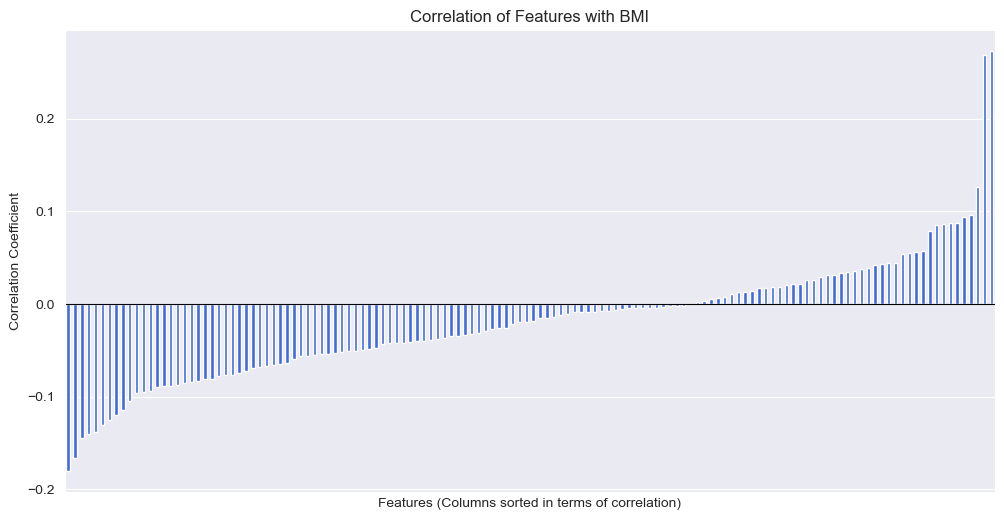

In [20]:
correlations = df2.corr()['BMI'].drop('BMI').sort_values()

plt.figure(figsize=(12, 6))
correlations.plot(kind='bar', color='royalblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Correlation of Features with BMI')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features (Columns sorted in terms of correlation)')
plt.xticks([], [])
plt.savefig('all_features_correlations_with_BMI.png')
plt.show()


**It can be observed that few of the features exhibit strong correlations/anti-correlations with the BMI values. Those will be kept.**

Host age                           0.272862
Eubacterium sulci                  0.268208
Desulfonispora thiosulfatigenes    0.180255
Sex                                0.165777
Sporobacter termitidis             0.145110
Clostridium clariflavum            0.140039
Alistipes putredinis               0.138521
Ruminococcus champanellensis       0.130119
Clostridium symbiosum              0.125778
Ruminiclostridium thermocellum     0.125688
Name: BMI, dtype: float64
['Host age', 'Eubacterium sulci', 'Desulfonispora thiosulfatigenes', 'Sex', 'Sporobacter termitidis', 'Clostridium clariflavum', 'Alistipes putredinis', 'Ruminococcus champanellensis', 'Clostridium symbiosum', 'Ruminiclostridium thermocellum']


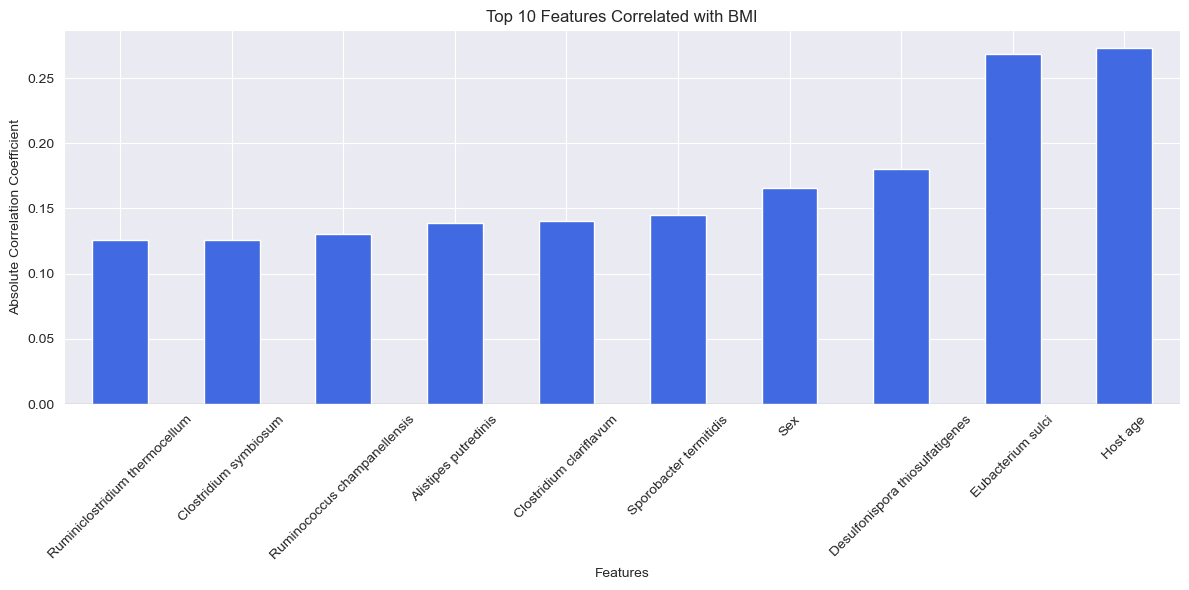

In [30]:
correlations = df2.corr()['BMI'].drop('BMI')
k_features_to_keep = 10
top_k = correlations.abs().nlargest(k_features_to_keep)
top_k_columns = top_k.index.tolist()
print(top_k)


# selector = SelectKBest(score_func=f_regression, k=20)
# top_k = selector.fit_transform(df2.drop(columns=['BMI']), df2['BMI'])
#
# top_k_columns = df2.columns[selector.get_support()]

print(top_k_columns)

df3 = df2[ top_k_columns + ['BMI']]

plt.figure(figsize=(12, 6))
top_k.sort_values().plot(kind='bar', color='royalblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f'Top {k_features_to_keep} Features Correlated with BMI')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks([], [])
plt.savefig('selected_features_correlation_with_BMI.png')
plt.show()

## Section 3.4: Visualization of the selected columns

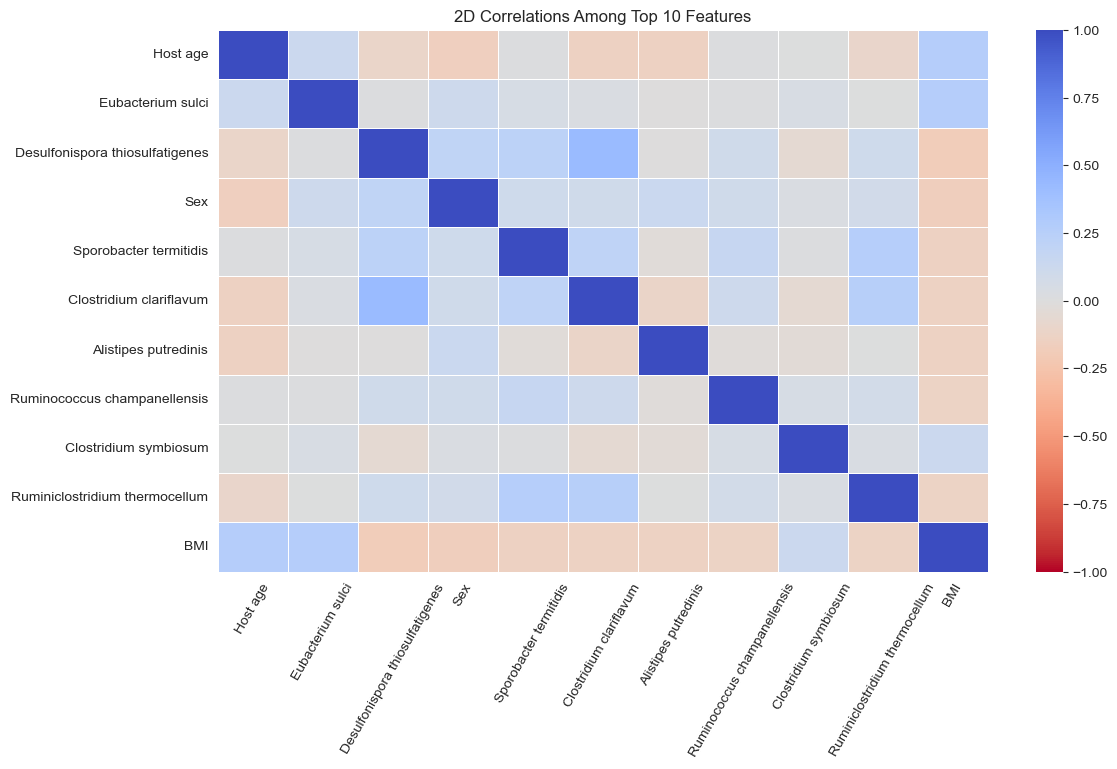

In [35]:
correlation_matrix = df3.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm_r", vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title(f'2D Correlations Among Top {k_features_to_keep} Features')
plt.savefig('selected_figures_correlations_with_eachother.png')
plt.show()

**There are various positive and negative correlations between the selected features which implies that a lot of information has been maintained in the selected columns**

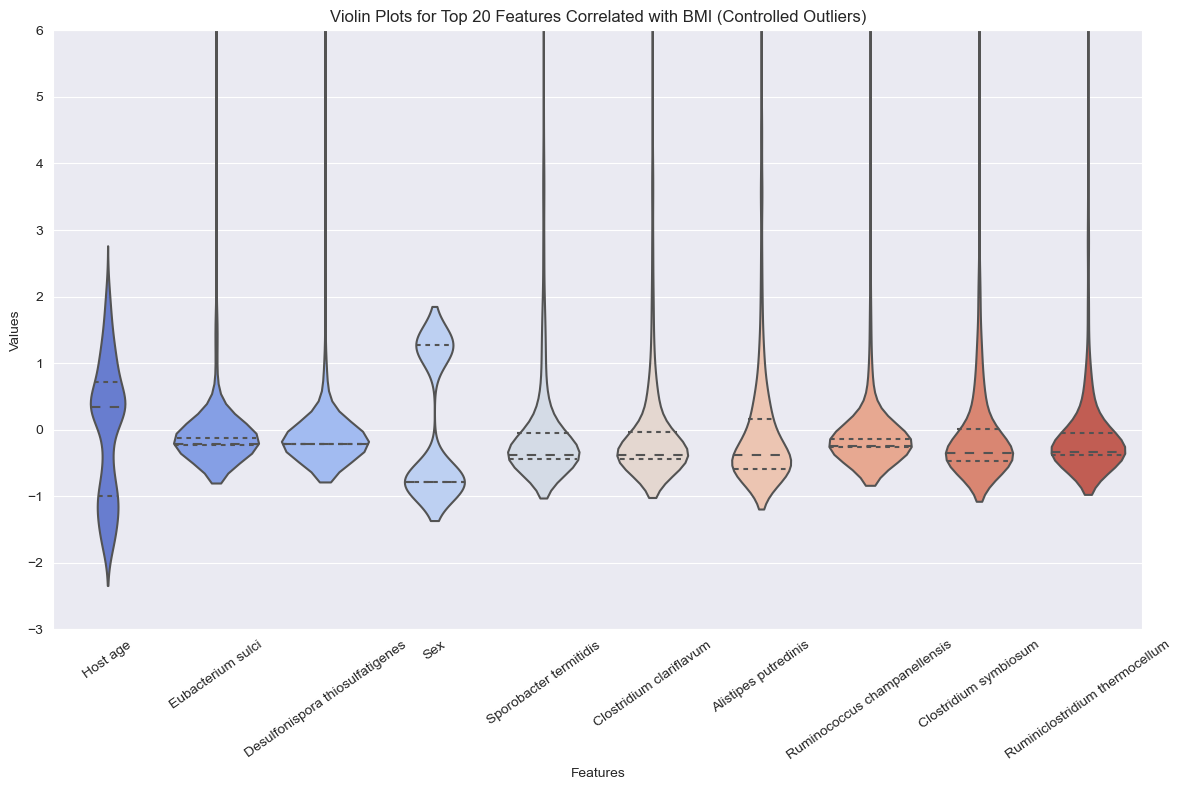

In [23]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=df3.drop(columns=['BMI']), inner="quart", palette="coolwarm")
plt.title('Violin Plots for Top 20 Features Correlated with BMI (Controlled Outliers)')
plt.ylabel('Values')
plt.xlabel('Features')
plt.xticks(rotation=35)
plt.ylim([-3,6])
plt.tight_layout()
plt.savefig('selected_features_distribution_plots.png')
plt.show()


**Each feature follows its own particular distribution, while there are numerous outliers on higher positive (normalized) values**

# Section 4: Save development files
- Save the standarized dataset with all columns (apart from the categorical ones discarded)
- Save the standarized dataset with only the selected columns

In [24]:
df2.to_csv(out_file_dev, index=False)

In [25]:
name_before_extension          = out_file_dev.split('.csv')[0]
selected_features_filename_dev = name_before_extension + '_' + str(k_features_to_keep) + '.csv'
df3.to_csv(selected_features_filename_dev, index=False)

# Section 5: Repeat the preprocessing and save validation files
- The pre-trained scaler is used to avoid data leakage.
- The same columns were kept as in the development set.

In [26]:
df_val  = pd.read_csv(inp_file_val)
df_val['Sex'] = df_val['Sex'].map({'Male': 0, 'Female': 1})

df2_val = df_val[df2.columns]
df2_val = df2_val.drop(columns=['BMI'])
df2_val = pd.DataFrame(scaler.transform(df2_val), columns=df2_val.columns) # use the pre-fitted scaler to avoid data leakage
df2_val['BMI'] = df_val['BMI']
df3_val = df2_val[top_k_columns+['BMI']] # keep the columns determined from the development set

df2_val.to_csv(out_file_val, index=False)

name_before_extension = out_file_val.split('.csv')[0]
selected_features_filename_val = name_before_extension + '_' + str(k_features_to_keep) + '.csv'
df3_val.to_csv(selected_features_filename_val, index=False)



The validation set contains 211 data instances.
